In [1]:
import os
from sys import getsizeof
import json
import re
import pickle
from time import perf_counter
import inspect
import numpy as np
import nltk
import matplotlib.pyplot as plt
import torch
from transformers import (
	BartTokenizer, BartForConditionalGeneration,
	T5Tokenizer, T5ForConditionalGeneration
)
from transformers.tokenization_utils_base import BatchEncoding
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from bert_score import BERTScorer
from rouge import Rouge

from utils.pipelines import *
from utils.helpers import *

In [2]:
# data_dir = "/Users/naman/Workspace/Data/UCCS-REU"
data_dir = "/home/nchibbar/Data"

crs_files = os.listdir(crs_dir := f"{data_dir}/GovReport/crs")
gao_files = os.listdir(gao_dir := f"{data_dir}/GovReport/gao")

print(f"crs files: {len(crs_files)}, gao files: {len(gao_files)}")

crs_out = f"{data_dir}/GovReport/crs-processed"
gao_out = f"{data_dir}/GovReport/gao-processed"

crs files: 7238, gao files: 12228


In [3]:
max_tokens = 512

# BART
bart_dir = f"{data_dir}/Models/BART"
bart_fine_tuned = f"{data_dir}/Models/BART-GovReport-SentenceSampler"
bart_checkpoint = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(bart_dir)
model = BartForConditionalGeneration.from_pretrained(bart_dir)
context_size = model.config.max_position_embeddings

# T5
# t5_dir = f"{data_dir}/Models/T5"
# t5_checkpoint = "google/flan-t5-base"
# t5_checkpoint = "pszemraj/long-t5-tglobal-base-16384-book-summary"
# tokenizer = T5Tokenizer.from_pretrained(t5_dir)
# model = T5ForConditionalGeneration.from_pretrained(t5_dir)
# context_size = model.config.n_positions

context_size

1024

In [4]:
special_tokens = extract_special_tokens(
	tokenizer.special_tokens_map.values()
)
preprocessor = TextProcessor(preprocessing=True)
postprocessor = None
# postprocessor = TextProcessor(ignore_tokens=special_tokens)
special_tokens

['<s>', '</s>', '<unk>', '</s>', '<pad>', '<s>', '<mask>']

## GovReport

In [ ]:
def combine_subsections(sections):
	text = ""
	for sec in sections:
		sec_text = "\n\n".join(sec["paragraphs"])
		if sec["section_title"]:
			sec_text = f"Section {sec["section_title"]}:\n\n{sec_text}"
		text = f"{text}\n\n{sec_text}" if text else sec_text
		if sec["subsections"]:
			sub_text = combine_subsections(sec["subsections"])
			text = f"{text}\n\n{sub_text}" if text else sub_text
	return text

In [ ]:
for file in crs_files:
	with open(f"{crs_dir}/{file}") as fp:
		data = json.load(fp)
	text = combine_subsections([data["reports"]])
	text = preprocessor.process(text)
	summary = "\n".join(data["summary"])
	summary = preprocessor.process(summary)
	with open(f"{crs_out}/{file}", "w") as fp:
		json.dump({
			"text": text,
			"summary": summary
		}, fp)

In [ ]:
for file in gao_files:
	with open(f"{gao_dir}/{file}") as fp:
		data = json.load(fp)
	text = combine_subsections(data["report"])
	text = preprocessor.process(text)
	print(data["highlight"])
	summary = "\n".join(data["highlight"])
	summary = preprocessor.preprocess(summary)
	with open(f"{gao_out}/{file}", "w") as fp:
		json.dump({
			"text": text,
			"summary": summary
		}, fp)

## LDA

In [ ]:
vectorizer = CountVectorizer(stop_words="english")
vectorizer

In [ ]:
dtm = vectorizer.fit_transform([data["text"]])
vectorizer

In [ ]:
print(dtm)

In [ ]:
topics = 4
lda = LatentDirichletAllocation(n_components=topics)
lda.fit(dtm)

In [ ]:
topic_dist = lda.transform(dtm)
print(topic_dist)

In [ ]:
def display_topics(model, feature_names, num_top_words):
	for topic_idx, topic in enumerate(model.components_):
		print(f"Topic {topic_idx}:")
		print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [ ]:
num_top_words = 10
feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, num_top_words)

## Rough

In [5]:
texts, summaries = [], []

In [6]:
# max 73_791
min_words_text = 70_000
for file in crs_files:
	with open(f"{crs_out}/{file}") as fp:
		data = json.load(fp)
	if count_words(data["text"]) >= min_words_text:
		break
texts.append(data["text"])
summaries.append(data["summary"])

count_words(data["text"]), count_words(data["summary"])

(70163, 364)

In [ ]:
texts, summaries = [], []
for file in crs_files:
	with open(f"{crs_out}/{file}") as fp:
		data = json.load(fp)
	texts.append(data["text"])
	summaries.append(data["summary"])

len(texts)

In [7]:
sent_checkpoint = "sentence-transformers/all-MiniLM-L6-v2"
sent_dir = f"{data_dir}/Models/Sent-Transformer"

sent_encoder = SentenceTransformer(sent_dir)
sent_encoder

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [8]:
head_size = .5
threshold = .85
seed = 69
device = get_device()
# device = "cpu"

encoders = [
	TruncateMiddle(
		tokenizer, context_size, head_size, preprocessor
	),
	UniformSampler(
		tokenizer, context_size, nltk.sent_tokenize, preprocessor, seed
	),
	SentenceSampler(
		tokenizer, context_size, nltk.sent_tokenize, sent_encoder,
		preprocessor, threshold, device, seed
	),
	RemoveRedundancy(
		tokenizer, context_size, nltk.sent_tokenize, sent_encoder,
		preprocessor, threshold, device, seed
	),
]

pipelines = [
	SummarizationPipeline(model, encoder, max_tokens, postprocessor, device)
	for encoder in encoders
]

In [ ]:
print(texts[0])

Section Introduction:

This is an outline of two federal statutes: the Electronic Communications Privacy Act (ECPA) and the Foreign Intelligence Surveillance Act (FISA). Both evolved out of the shadow of the Supreme Court's Fourth Amendment jurisprudence. The courts play an essential role in both. Congress crafted both to preserve the ability of government officials to secure information critical to the nation's well-being and to ensure individual privacy. It modeled parts of FISA after features in ECPA. There are differences, however. ECPA protects individual privacy from the intrusions of other individuals. FISA has no such concern. FISA authorizes the collection of information about the activities of foreign powers and their agents, whether those activities are criminal or not. ECPA's only concern is crime.

Section Background:

At common law, "eavesdroppers, or such as listen under walls or windows, or the eaves of a house, to hearken after discourse, and thereupon to frame slander

In [10]:
print(preprocessor(texts)[0])

Section Introduction:

This is an outline of two federal statutes: the Electronic Communications Privacy Act (ECPA) and the Foreign Intelligence Surveillance Act (FISA). Both evolved out of the shadow of the Supreme Court's Fourth Amendment jurisprudence. The courts play an essential role in both. Congress crafted both to preserve the ability of government officials to secure information critical to the nation's well-being and to ensure individual privacy. It modeled parts of FISA after features in ECPA. There are differences, however. ECPA protects individual privacy from the intrusions of other individuals. FISA has no such concern. FISA authorizes the collection of information about the activities of foreign powers and their agents, whether those activities are criminal or not. ECPA's only concern is crime.

Section Background:

At common law, "eavesdroppers, or such as listen under walls or windows, or the eaves of a house, to hearken after discourse, and thereupon to frame slander

In [9]:
# enc = tokenizer(texts)["input_ids"][0]
enc = encoders[1](texts)["input_ids"][0]

print(tokenizer.decode(enc))

<s>"Wire communications" are limited to those that are at some point involve voice communications (i.e., only aural transfers).

Section FISA Electronic Surveillance and Physical Search Orders:

Section Government Access:

The FISA electronic surveillance and physical search components use generally parallel procedures.

2709; provided the assistance pursuant to 18 U.S.C.

Any such disclosure, shall render such person liable for the civil damages provided for in section 2520 No cause of action shall lie in any court against any provider of wire or electronic communication service, its officers, employees, or agents, landlord, custodian, or other specified person for providing information, facilities, or assistance in accordance with the terms of a court order, statutory authorization, or certification under this chapter.

(2) Any investigative or law enforcement officer who, by any means authorized by this chapter, has obtained knowledge of the contents of any wire, oral, or electronic

In [9]:
batch_size = None if len(texts) < 3 else 3
evaluator = Evaluator(
	pipelines, texts, summaries, device=device
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
evaluator.generate_summaries(batch_size)

[22529.993814998306, 19385.686802997952, 23740.515432000393, 114102.0073260006]

In [15]:
evaluator.get_rouge_score()

[{'rouge-1': array([0.07881505, 0.39801494, 0.04381384]),
  'rouge-2': array([0.0092141 , 0.04927629, 0.00508998]),
  'rouge-l': array([0.10601738, 0.38872851, 0.06148066]),
  'rouge-w': array([0.01665617, 0.20201155, 0.00869101])},
 {'rouge-1': array([0.07985993, 0.42174518, 0.04421659]),
  'rouge-2': array([0.00542675, 0.02924679, 0.00299664]),
  'rouge-l': array([0.10913477, 0.40795453, 0.06315046]),
  'rouge-w': array([0.0173585 , 0.21706709, 0.00905006])},
 {'rouge-1': array([0.0865571 , 0.40104155, 0.04883324]),
  'rouge-2': array([0.00357995, 0.01363636, 0.00206044]),
  'rouge-l': array([0.1112349, 0.3764925, 0.0656536]),
  'rouge-w': array([0.01813235, 0.194941  , 0.00954205])},
 {'rouge-1': array([0.08479274, 0.39276652, 0.04794122]),
  'rouge-2': array([0.01062947, 0.04936439, 0.00602607]),
  'rouge-l': array([0.10690865, 0.36669271, 0.06307668]),
  'rouge-w': array([0.01642158, 0.17955114, 0.00863377])}]

In [16]:
evaluator.get_bert_score()

[tensor([0.8138, 0.8254, 0.8233, 0.8213]),
 tensor([0.7712, 0.7729, 0.7749, 0.7747]),
 tensor([0.7919, 0.7983, 0.7983, 0.7972])]

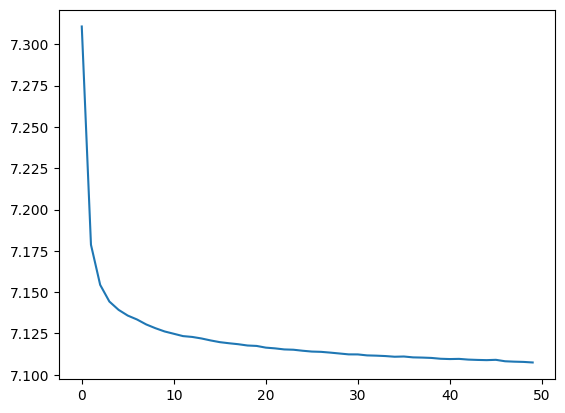

In [18]:
with open("/home/nchibbar/Data/train-history/bart-history.pkl", "rb") as fp:
	history = pickle.load(fp)

plt.plot(history)

In [43]:
nltk.sent_tokenize("Section 18 U.S.C 2510. Definitions.:\n\nAs used in this chapter")

['Section 18 U.S.C 2510.67 Definitions.', ':\n\nAs used in this chapter']

In [38]:
nltk.sent_tokenize(texts[0])

['Section Introduction:\n\nThis is an outline of two federal statutes: the Electronic Communications Privacy Act (ECPA) and the Foreign Intelligence Surveillance Act (FISA).',
 "Both evolved out of the shadow of the Supreme Court's Fourth Amendment jurisprudence.",
 'The courts play an essential role in both.',
 "Congress crafted both to preserve the ability of government officials to secure information critical to the nation's well-being and to ensure individual privacy.",
 'It modeled parts of FISA after features in ECPA.',
 'There are differences, however.',
 'ECPA protects individual privacy from the intrusions of other individuals.',
 'FISA has no such concern.',
 'FISA authorizes the collection of information about the activities of foreign powers and their agents, whether those activities are criminal or not.',
 "ECPA's only concern is crime.",
 'Section Background:\n\nAt common law, "eavesdroppers, or such as listen under walls or windows, or the eaves of a house, to hearken af